In [7]:
import numpy as np
import os
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import seaborn as sns
import codebase
from codebase.dataprocessing import LSTM_preprocessing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# Selct location
res_name = 'Powell'
grdc_id = 4152050

In [4]:
# Filepaths
grdc_dir = '/global/scratch/users/ann_scheliga/aux_dam_datasets/GRDC_CRB/'
met_dir = '/global/scratch/users/ann_scheliga/era5_test_data/'
res_dir = '/global/scratch/users/ann_scheliga/CYGNSS_daily/'

In [5]:
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

2024-12-06 09:14:56.343950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 09:14:56.347228: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 09:14:56.357679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733505296.375183 1236378 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733505296.380359 1236378 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 09:14:56.398207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## LOAD from function

In [9]:
all_data = LSTM_preprocessing(res_name = 'Powell', dam_name = 'glen canyon', grdc_id = 4152050)

Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area


## Split data

In [26]:
X = all_data.drop(columns=['Q m3s'])[:-6].values
y = all_data['Q m3s'][:-6].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=23,shuffle=False)
X_train = X_train.reshape(1,X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(1,X_test.shape[0],X_test.shape[1])
y_train = y_train.reshape(1,y_train.shape[0],1)
y_test = y_test.reshape(1,y_test.shape[0],1)

X_met_train = X_train[:,:,:-1].copy()
X_met_test = X_test[:,:,:-1].copy()

In [43]:
print(f'X train shape: {X_train.shape}; y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}; y test shape: {y_test.shape}')

X train shape: (1, 910, 3); y train shape: (1, 910, 1)
X test shape: (1, 910, 3); y test shape: (1, 910, 1)


## Create and fit model

In [52]:
def make_LSTM_model(n_timesteps_in,n_features):
    model = Sequential()
    model.add(Input(shape=(n_timesteps_in,n_features)))
    # model.add(Dense(128, activation='sigmoid'))
    model.add(LSTM(150,dropout=0.2))
    model.add(RepeatVector(n_timesteps_in))
    model.add(LSTM(150, return_sequences=False))
    # model.add(TimeDistributed(Dense(n_features, activation='softmax')))
    
    model.add(Dense(n_timesteps_in, activation= "relu"))
    model.compile(loss='MeanSquaredError', optimizer='adam', 
                  metrics=['MeanAbsoluteError'])
    print(model_nw.summary())
    return model

In [61]:
n_timesteps_in = X_train.shape[-2]
n_features = X_train.shape[-1]
n_timesteps_out = 1
n_epochs = 300
print(n_timesteps_in, n_features)

910 3


In [62]:
model_nw = make_LSTM_model(n_timesteps_in,2)
model_nw_history = model_nw.fit(X_met_train, y_train, epochs=n_epochs, batch_size=38,validation_data=(X_met_test, y_test))

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 150)            │        91,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_13 (RepeatVector) │ (None, 910, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 910)            │       137,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,229,432 (4.69 MB)

 Trainable params: 409,810 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 819,622 (3.13 MB)

None
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - MeanAbsoluteError: 30.9668 - loss: 1167.0199 - val_MeanAbsoluteError: 28.5118 - val_loss: 963.1442
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step - MeanAbsoluteError: 30.9300 - loss: 1164.6501 - val_MeanAbsoluteError: 28.4601 - val_loss: 960.1907
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step - MeanAbsoluteError: 30.8781 - loss: 1161.3678 - val_MeanAbsoluteError: 28.3947 - val_loss: 956.4561
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 31.0067 - loss: 1169.4550 - val_MeanAbsoluteError: 28.3338 - val_loss: 952.9792
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 30.7520 - loss: 1153.5645 - val_MeanAbsoluteError: 28.2629 - val_loss: 948.9354
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 30.6812 - loss: 1149.2529 - val_MeanAbsoluteError: 28.1829 - val_loss: 944.3918
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 30.6013 - loss: 1144.4248 

In [63]:
model_sw = make_LSTM_model(n_timesteps_in, 3)
model_sw_history = model_sw.fit(X_train, y_train, epochs=n_epochs, batch_size=38,validation_data=(X_test, y_test))

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 150)            │        91,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_15 (RepeatVector) │ (None, 910, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 910)            │       137,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,229,432 (4.69 MB)

 Trainable params: 409,810 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 819,622 (3.13 MB)

None
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - MeanAbsoluteError: 30.9663 - loss: 1167.0890 - val_MeanAbsoluteError: 28.5476 - val_loss: 965.2529
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step - MeanAbsoluteError: 30.9722 - loss: 1167.3400 - val_MeanAbsoluteError: 28.5354 - val_loss: 964.5696
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 30.9535 - loss: 1166.2317 - val_MeanAbsoluteError: 28.5098 - val_loss: 963.1342
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 31.0079 - loss: 1169.5342 - val_MeanAbsoluteError: 28.4838 - val_loss: 961.6619
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 30.9039 - loss: 1163.0337 - val_MeanAbsoluteError: 28.4501 - val_loss: 959.7545
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 30.8620 - loss: 1160.5898 - val_MeanAbsoluteError: 28.4013 - val_loss: 956.9819
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step - MeanAbsoluteError: 30.8114 - loss: 1157.4915 

In [64]:
## Evaluate model (train/test)
def plot_epoch_error(history_dict):
    """
    Plots the training and validation metrics of a neural network.
    """
    
    acc = history_dict['MeanAbsoluteError']
    val_acc = history_dict['val_MeanAbsoluteError']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color = 'navy', alpha = 0.8, label='Training MAE')
    plt.plot(epochs, val_acc, color = 'green', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    return plt.show()

In [87]:
def compare_epoch_error(history_nw, history_sw, fig_name = ''):
    error_nw = history_nw['MeanAbsoluteError']
    val_error_nw = history_nw['val_MeanAbsoluteError']
    error_sw = history_sw['MeanAbsoluteError']
    val_error_sw = history_sw['val_MeanAbsoluteError']
    epochs = range(1, len(error_nw) + 1)
    plt.plot(epochs, error_nw, color = 'navy', linestyle=':', alpha = 0.8, label='Training MAE met only')
    plt.plot(epochs, val_error_nw, color = 'green', linestyle=':', alpha = 0.8, label='Validation MAE met only')
    plt.plot(epochs, error_sw, color = 'navy', linestyle='-', alpha = 0.8, label='Training MAE with SW')
    plt.plot(epochs, val_error_sw, color = 'green', linestyle='-', alpha = 0.8, label='Validation MAE with SW')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    if fig_name:
        plt.savefig('../figures/'+fig_name+'.png')
    return plt.show()

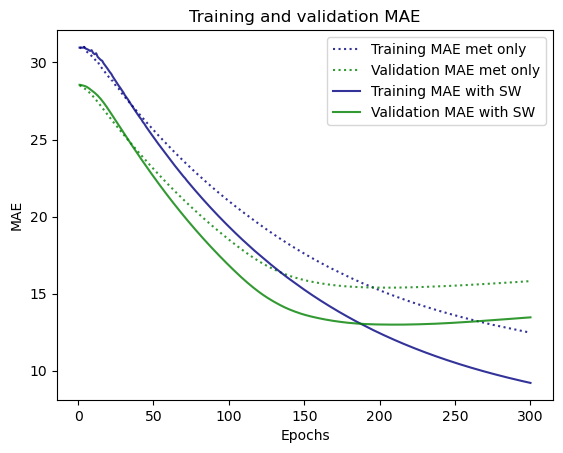

In [89]:
compare_epoch_error(model_nw_history.history,model_sw_history.history,fig_name='Powell_MAE')


## Load data

In [5]:
# Load reservoir dataset
res_shp = codebase.load_data.load_GRanD()
res_name_dict = {'Powell':'glen canyon',
                 'Mead': 'hoover',
                 'Mohave': 'davis bor',
                 'Havasu': 'parker'}

In [326]:
# Load subset CYGNSS reservoir data
sw_area = pd.read_csv(res_dir+res_name_dict[res_name]+'_area.csv', index_col = 0)
sw_area.index = pd.to_datetime(sw_area.index)
sw_area = sw_area.loc[sw_area.index < pd.to_datetime('2024-01-01'),'Area m2']

sw_area = (sw_area/10**6).rename('Area km2',inplace=True)

In [327]:
# Load GRDC data
watershed_gpd, grdc_Q = codebase.load_data.load_GRDC_station_data_by_ID(grdc_id,filepath=grdc_dir,timeseries_dict={'start_year':2019,'stop_year':2024})

In [329]:
# Load ERA5 data, subset to GRDC watershed
tempK_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_tempK')
precip_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_tot_precip')
type_precip_files = codebase.utils.grab_matching_names_from_filepath(met_dir,r'daily_precip_type')

concat_dict = {'dim':'valid_time'}

tempK_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=tempK_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)
precip_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=precip_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)
type_precip_xr = codebase.area_subsets.era5_shape_subset_and_concat(ordered_filenames=type_precip_files,
                                                                 filepath=met_dir,
                                                                 concat_dict=concat_dict,
                                                                subset_gpd=watershed_gpd)

Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!


## Calculate inputs

Projected to equal area


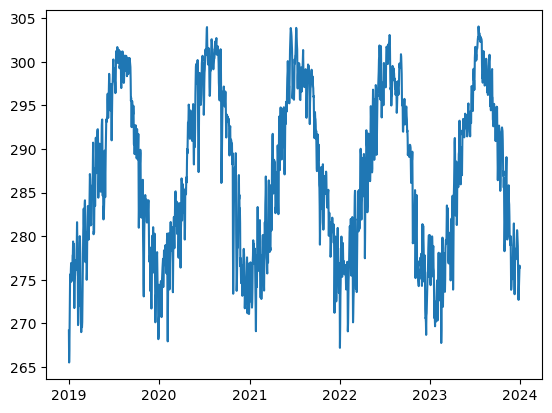

In [55]:
# Areal-average of temperature
tempK_1dim = codebase.X_calcs.CYGNSS_001_areal_average(tempK_xr,x_dim = 'longitude', y_dim = 'latitude',with_index = 'valid_time')
tempK_1dim.rename('Temp K',inplace=True)
plt.plot(tempK_1dim)

Projected to equal area


<Axes: >

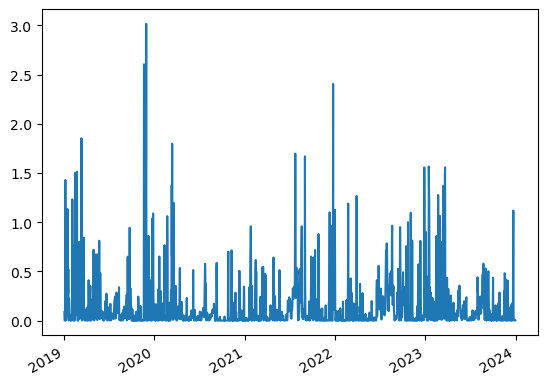

In [57]:
# Areal sum of precip
precip_1dim = codebase.X_calcs.CYGNSS_001_areal_aggregation(np.nansum,precip_xr,x_dim = 'longitude', y_dim = 'latitude',with_index = 'valid_time')
precip_1dim.rename('Precip m',inplace=True)
precip_1dim.plot()

In [66]:
# [troubleshooting] precip data is missing the first day of each year...
nan_dates = pd.date_range(start = precip_1dim.index.min(), end = precip_1dim.index.max(), freq = 'D').difference(precip_1dim.index)

In [332]:
all_data = pd.concat([tempK_1dim, precip_1dim, sw_area, grdc_Q],axis=1)
all_data.interpolate(method='linear',axis=0,inplace=True) # interpolate missing interiror values
all_data.bfill(inplace=True) # backfill missing first value
all_data.head()

,Temp K,Precip m,Area km2,Q m3s
2019-01-01,269.161835,8.643866e-02,380.752060,30.582
2019-01-02,265.507812,8.643866e-02,362.621009,36.812
2019-01-03,266.982941,2.808571e-04,356.895415,35.962
2019-01-04,270.215485,9.536743e-07,354.986883,35.962
2019-01-05,272.525360,2.046108e-03,354.032617,36.529


## Linear Regression
(bad, done for shits and giggles)

In [81]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [82]:
print(f'Training R^2: {model.score(X_train, y_train)}')
print(f'Test R^2: {model.score(X_test, y_test)}')

Training R^2: 0.013474996806106199
Test R^2: 0.014052436280964087


In [84]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = model.predict(X)

In [85]:
print(f'Train RMSE: {mean_squared_error(y_train, y_train_pred, squared=False)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_test_pred, squared=False)}')

Train RMSE: 13.162629063194156
Test RMSE: 13.998738609585978


In [86]:
model.coef_ , model.intercept_

(array([-7.67612747e-02,  3.67865639e+00,  1.58712155e-08]), 46.82833597997587)